In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image as pil_image
from IPython.display import Image as Image
from matplotlib.pyplot import imshow, imsave

np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf

import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:49<00:00, 36.9MB/s]
100% 5.20G/5.20G [01:49<00:00, 50.9MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
main_df = pd.read_csv('HAM10000_metadata.csv')
main_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


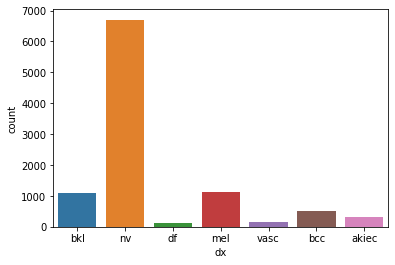

In [ ]:
sns.countplot(main_df['dx'])

In [ ]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

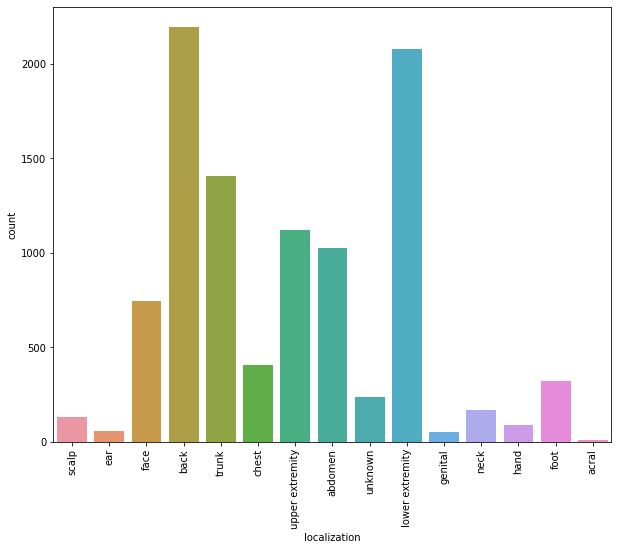

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


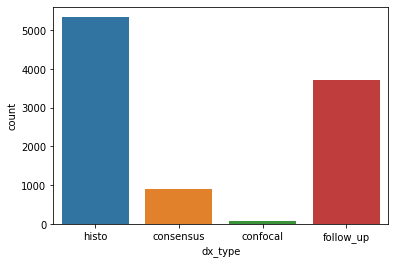

In [ ]:
sns.countplot(main_df['dx_type'])

In [ ]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [ ]:
main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

In [ ]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


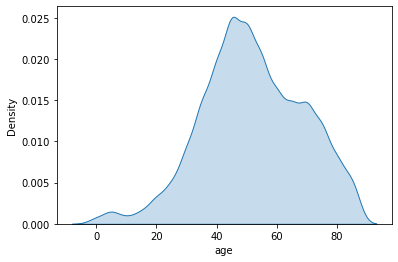

In [ ]:
sns.kdeplot(main_df['age'],shade=True)

In [ ]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [ ]:
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

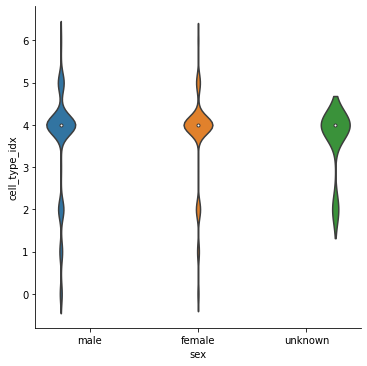

In [ ]:
sns.catplot(x="sex", y="cell_type_idx",
                    hue="sex",
                    data=main_df,
                    kind="violin")

In [ ]:
import os
#pil_image = os.path.join('images')
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('', '*', '*.jpg'))}

In [ ]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

lesion_id  ...                                     path
0  HAM_0000118  ...  HAM10000_images_part_1/ISIC_0027419.jpg
1  HAM_0000118  ...  HAM10000_images_part_1/ISIC_0025030.jpg
2  HAM_0002730  ...  HAM10000_images_part_1/ISIC_0026769.jpg
3  HAM_0002730  ...  HAM10000_images_part_1/ISIC_0025661.jpg
4  HAM_0001466  ...  ham10000_images_part_2/ISIC_0031633.jpg

[5 rows x 10 columns]

In [ ]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [ ]:
image_example.shape

(450, 600, 3)

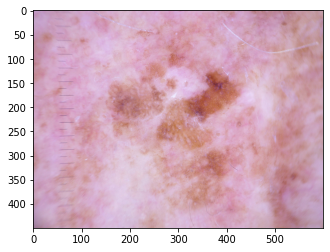

In [ ]:
plt.imshow(image_example)

In [ ]:
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,100))))

In [ ]:
main_df.head()

lesion_id  ...                                              image
0  HAM_0000118  ...  [[[188, 151, 193], [193, 156, 197], [192, 155,...
1  HAM_0000118  ...  [[[24, 13, 22], [23, 13, 22], [24, 14, 25], [2...
2  HAM_0002730  ...  [[[185, 126, 135], [188, 131, 142], [191, 136,...
3  HAM_0002730  ...  [[[23, 11, 16], [24, 11, 19], [27, 13, 23], [3...
4  HAM_0001466  ...  [[[129, 87, 109], [139, 95, 118], [148, 103, 1...

[5 rows x 11 columns]

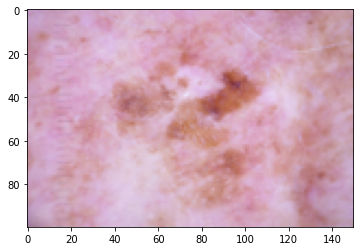

In [ ]:
plt.imshow(main_df['image'][0])

In [ ]:
main_df['image'][0].shape

(100, 150, 3)

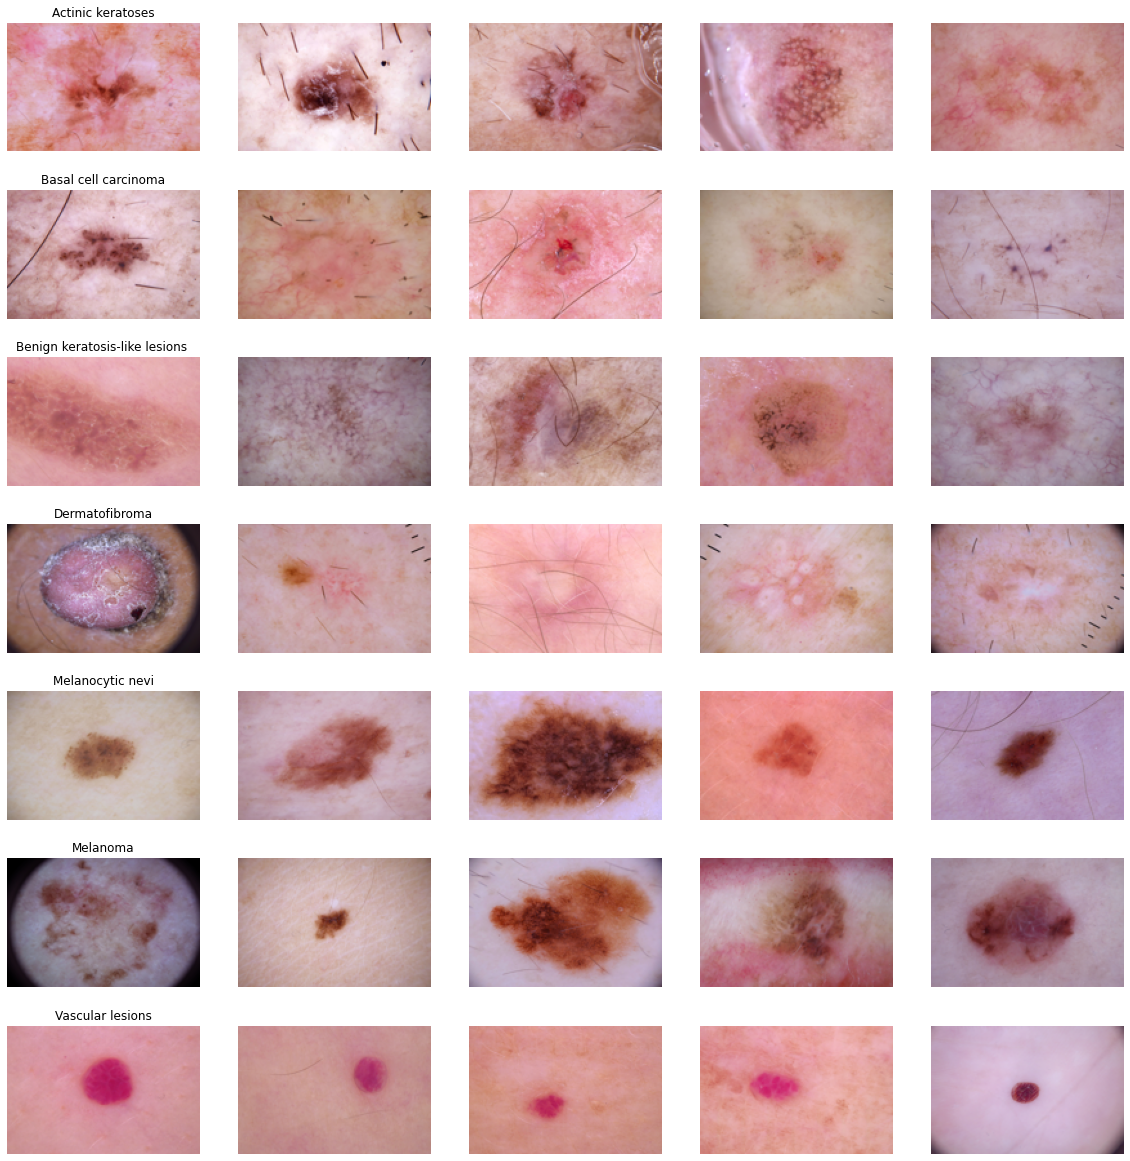

In [ ]:
fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

In [ ]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [ ]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [ ]:
print(x_train.shape)
print(x_test.shape)

(9914, 100, 150, 3)
(101, 100, 150, 3)


In [ ]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train-x_train_mean) / x_train_std
x_test = (x_test-x_test_mean) / x_test_std

In [ ]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [ ]:
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

In [ ]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [ ]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [ ]:
X_train  = X_train.reshape(X_train.shape[0],100,150,3)
x_test  = x_test.reshape(x_test.shape[0],100,150,3)
X_val  = X_val.reshape(X_val.shape[0],100,150,3)

In [ ]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 100, 150, 3)
(101, 100, 150, 3)
(1488, 100, 150, 3)


In [ ]:
input_shape = (100, 150, 3)
num_classes = 7
from keras.models import Sequential , Model
from keras.layers import Dropout , GlobalAveragePooling2D
model = InceptionV3(weights="imagenet",
include_top=False , input_shape=(100, 150, 3))
x = model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='sigmoid')(x)
model = Model(inputs=model.input, outputs=predictions)
model.summary()



87916544/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 74, 32)   0           batch_normalization[0][0]        
_____________________________

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)


In [ ]:
epochs = 20
batch_size = 32

history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val,Y_val),
    validation_steps=X_val.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

In [ ]:
model.save('/content/drive/MyDrive/Skin_Models/model_ResNet.h5')

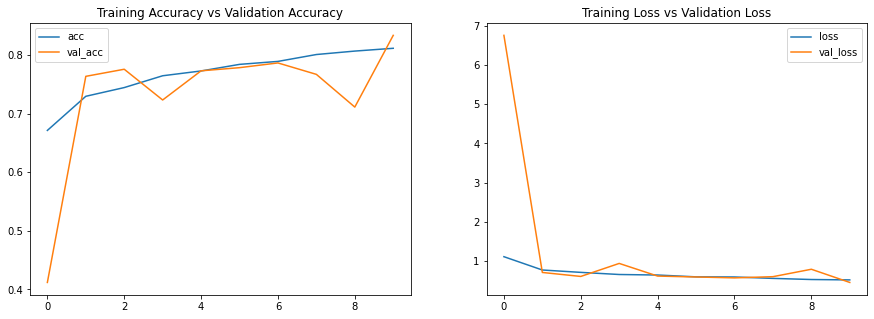

In [ ]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [ ]:
print("MAXIMUM ACCURACY OF RESNET NETWORK is : ", round(max(model.history.history['val_accuracy'])*100,4))

MAXIMUM ACCURACY OF RESNET NETWORK is :  83.3333
